<hr style="border-top-width:4px; border-top-color: #00df;">

# Analysis of Covid-19 papers

<hr>

* Mojtaba Roshana
* Roya Joulaei

<hr>

* Luca Giorgetti
* Emerson Rodrigues Vero filho

<hr style="border-top-width:4px; border-top-color: #00df;">


# Introduction

This distributed computing aims to study the performance of a dask cluster on the analysis of a dataset containing 1000 scientific papers about COVID-19, SARS-CoV-2, and related coronaviruses. This dataset is a sub-sample of 1000 items taken from the original one which is composed of more than 75000 (and still growing) papers. The whole dataset is available on Kaggle and the latest revision (i.e. 111) has size of 87.52 GiB, whereas the reduced one has size of 66 MB.\
As a preliminary stage all the items in the dataset have to be flattened. We did it using the following function:

```python
#this script selects json file from the data folder, transforms them in one line strings and copy them in the destination folder.

import os
import json

#creating destination folder if does not exist
dest_fold = '/mnt/papers_one_line'
if not os.path.exists(dest_fold):
	os.makedirs(dest_fold)

#data folder
data_path = '/mnt/papers'

filenames = os.listdir(data_path)
for fname in filenames:
	f = open(data_path + '/' + fname)
	obj = json.load(f)                                   
	flatten_str = json.dumps(obj)                        
	jsonFile = open(dest_fold + '/one_line_' + fname,'w')
	jsonFile.write(flatten_str)
	jsonFile.close
	f.close
```

In [ ]:
import dask
from dask.distributed import Client, SSHCluster
from dask import delayed
import dask.bag as db
import dask.dataframe as ddf
import numpy as np
import csv
import functools
import seaborn as sn
import json
import time
import re
import timeit

from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk

from collections import Counter
from operator import add
from operator import itemgetter

import matplotlib.pyplot as plt

from operator import itemgetter
import numpy as np
from dask.utils import format_bytes
import itertools
from itertools import combinations
from numpy.linalg import norm
import os
import pandas as pd
import math
from collections import Counter
import networkx as nx
import tqdm

dask.config.set({'distributed.scheduler.allowed-failures': 5})
#dask.config.set({'distributed.comm.retry.count':10})

Three Virtual machines with the following Ip adresses and names were used as nodes for the deployment of the Dask Cluster.\
We used *stac3* as scheduler and worker and *stac4* and *stac5* as workers.

In [ ]:
stac3 = '10.67.22.180'
stac4 = '10.67.22.37'
stac5 = '10.67.22.94'

cluster = SSHCluster([stac3, stac3, stac4, stac5],
                    scheduler_options={"port": 0, "dashboard_address": ":8797"},
                    worker_options={"n_workers":3, "nthreads":8},
                    connect_options={"known_hosts": None})
client = Client(cluster)

2023-08-29 15:55:55,069 - distributed.deploy.ssh - INFO - 2023-08-29 15:55:55,068 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 15:55:55,095 - distributed.deploy.ssh - INFO - 2023-08-29 15:55:55,095 - distributed.scheduler - INFO - State start
2023-08-29 15:55:55,099 - distributed.deploy.ssh - INFO - 2023-08-29 15:55:55,098 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.180:44637
2023-08-29 15:55:55,854 - distributed.deploy.ssh - INFO - 2023-08-29 15:55:55,853 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.180:33347'
2023-08-29 15:55:55,857 - distributed.deploy.ssh - INFO - 2023-08-29 15:55:55,857 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.180:37771'
2023-08-29 15:55:55,859 - distributed.deploy.ssh - INFO - 2023-08-29 15:55:55,859 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.18

In [ ]:
#uploading data
filename = '/mnt/shared_folder/papers_one_line/*.json'

bag = db.read_text(filename)

js = bag.map(json.loads).repartition(10)

client

<Client: 'tcp://10.67.22.180:44637' processes=6 threads=48, memory=23.00 GiB>

## Task 1: word counter

In the first task we want to count the words used in the dateset in order to understand which are the most frequent.
We will do it in two main steps:

1. **Map phase**: for each document $D$, we are going to produce a set of intermediate pairs $(w, cp(w))$, one for each word $w \in D$, where $cp(w)$ is the number of occurrences of $w$ in $D$.
2. **Reduce phase**: for each word $w$, we gather all the pairs $(w, cp(w))$ and return the final pair $(w, c(w))$ where $c(w)$ is the number of occurrences of $w$ for all the Documents.

We are in particular interested in the <span style="color:red">"body text"</span> part of each document that is made of some *subsections*, we only need the *"text"* one.\
Before counting we are also going to clean the text, removing:

1. Words containing not alphabetic characters.
2. English stop words such as "the", "a", "in".
3. Some costume chosen words.

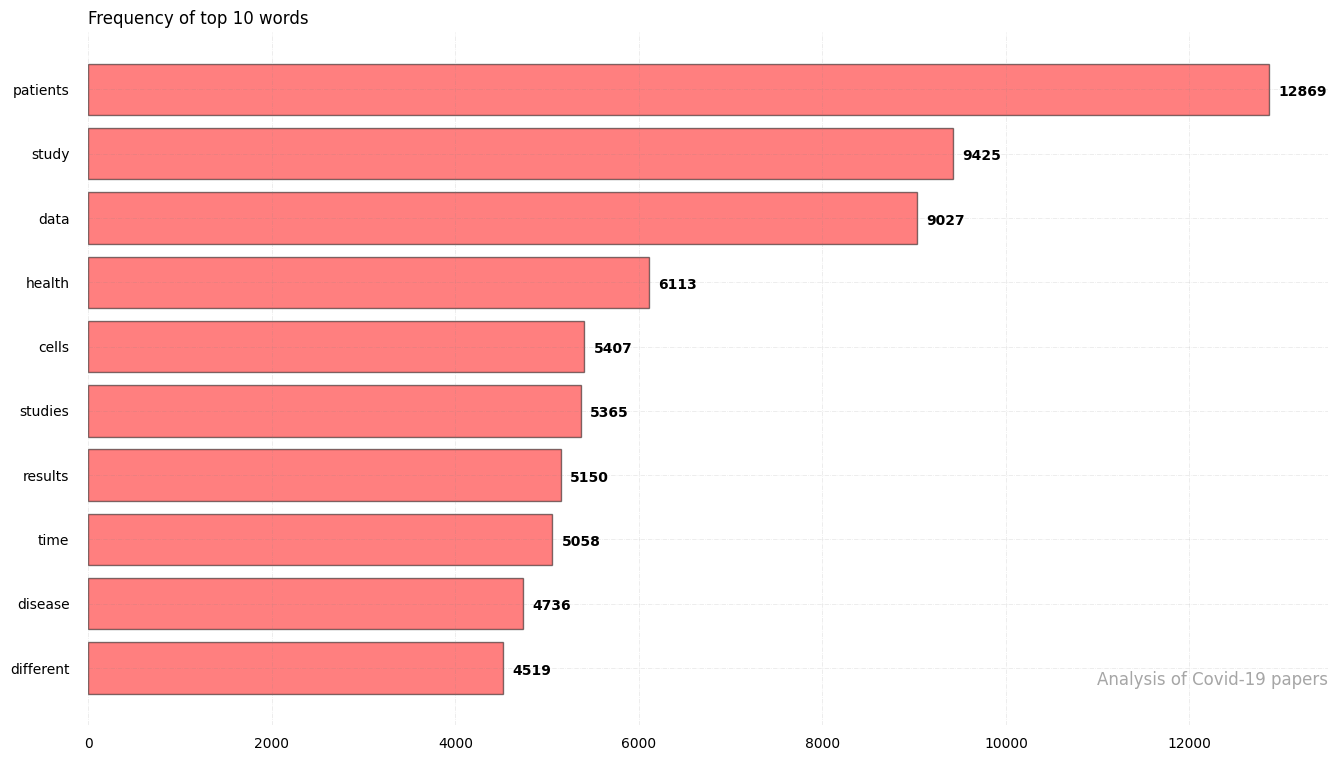

In [ ]:
def merge_json(data):
    all_text=''
    for t in data:
        all_text+=t['text']
    return all_text

def cleaner(text):
    stop_words = stopwords.words('english')
    text_tokens=word_tokenize(text)

    tokens_without_sw=[word.lower() for word in text_tokens if not word.lower() in stop_words and \
                       word.lower() not in out_words and word.isalpha()]
    return tokens_without_sw

def count(text):
    counts = dict(zip(Counter(text).keys(), Counter(text).values()))
    words_counted = [{"word":x , "frequency": y} for x,y in counts.items()]
    return words_counted

def sumation(total, x):
    return total+x['frequency']

#costumized list of words to esclude from counting
out_words = ['et', 'used', 'use', 'also', 'may', 'using', 'one', 'two', 'three', 'al']

#map phase
words = js.pluck("body_text").map(merge_json).map(cleaner).map(count)

#reduce phase
All_counts = words.flatten().foldby('word', binop=sumation,initial=0,combine=add,combine_initial=0).compute()

#plotting function
def plot_hist(labels, frequencies, title, count_space):

    fig, ax = plt.subplots(figsize =(16, 9))
    ax.barh(labels, frequencies, color = 'red', alpha = 0.5, edgecolor = 'black')
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    ax.grid(color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
    ax.invert_yaxis()
    for i in ax.patches:
        plt.text(i.get_width()+count_space, i.get_y()+0.5,
                str(round((i.get_width()), 2)),
                fontsize = 10, fontweight ='bold',
                color ='black')
    ax.set_title(title,
                loc ='left', )
    fig.text(0.9, 0.15, 'Analysis of Covid-19 papers', fontsize = 12,
            color ='grey', ha ='right', va ='bottom',
            alpha = 0.7)
    plt.show()

#plotting
All_counts_sorted = sorted(All_counts, key=itemgetter(1), reverse=True)
freq = [All_counts_sorted[i][1] for i in range(0,len(All_counts_sorted))]
word = [All_counts_sorted[i][0] for i in range(0,len(All_counts_sorted))]

plot_hist(labels = word[:10], frequencies = freq[:10], title = 'Frequency of top 10 words', count_space = 100)

## Optimization: Finding the best settings

Here we want to tune the parameters in order to find the best settings for the cluster. Once optimized we will use these parameters for the rest of the notebook. \
The paramaters we are going to optimize are the following:

1. **Number of cores per worker**
2. **Number of threads per worker**
3. **Number of partitions of the data**

2023-08-29 15:56:11,684 - distributed.deploy.ssh - INFO - 2023-08-29 15:56:11,683 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 15:56:11,711 - distributed.deploy.ssh - INFO - 2023-08-29 15:56:11,711 - distributed.scheduler - INFO - State start
2023-08-29 15:56:11,712 - distributed.deploy.ssh - INFO - 2023-08-29 15:56:11,711 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-aho7wp2p', purging
2023-08-29 15:56:11,713 - distributed.deploy.ssh - INFO - 2023-08-29 15:56:11,712 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ds7qaei8', purging
2023-08-29 15:56:11,713 - distributed.deploy.ssh - INFO - 2023-08-29 15:56:11,712 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xwviu0ko', purging
2023-08-29 15:56:11,717 - di

20.4 s ± 180 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
23.4 s ± 871 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
23.7 s ± 318 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
23.8 s ± 973 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


2023-08-29 16:05:24,526 - distributed.deploy.ssh - INFO - 2023-08-29 16:05:24,525 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 16:05:24,552 - distributed.deploy.ssh - INFO - 2023-08-29 16:05:24,551 - distributed.scheduler - INFO - State start
2023-08-29 16:05:24,553 - distributed.deploy.ssh - INFO - 2023-08-29 16:05:24,552 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9fps9equ', purging
2023-08-29 16:05:24,555 - distributed.deploy.ssh - INFO - 2023-08-29 16:05:24,554 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.180:40219
2023-08-29 16:05:25,344 - distributed.deploy.ssh - INFO - 2023-08-29 16:05:25,343 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.180:33323'
2023-08-29 16:05:25,497 - distributed.deploy.ssh - INFO - 2023-08-29 16:05:25,494 - distributed.nanny - INFO -   

19.5 s ± 762 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
21.8 s ± 305 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
23.9 s ± 1.46 s per loop (mean ± std. dev. of 3 runs, 2 loops each)
27 s ± 498 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


2023-08-29 16:14:43,099 - distributed.deploy.ssh - INFO - 2023-08-29 16:14:43,098 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 16:14:43,127 - distributed.deploy.ssh - INFO - 2023-08-29 16:14:43,126 - distributed.scheduler - INFO - State start
2023-08-29 16:14:43,128 - distributed.deploy.ssh - INFO - 2023-08-29 16:14:43,127 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3079t_aq', purging
2023-08-29 16:14:43,132 - distributed.deploy.ssh - INFO - 2023-08-29 16:14:43,132 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.180:37065
2023-08-29 16:14:43,889 - distributed.deploy.ssh - INFO - 2023-08-29 16:14:43,888 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.180:35545'
2023-08-29 16:14:44,093 - distributed.deploy.ssh - INFO - 2023-08-29 16:14:44,090 - distributed.nanny - INFO -   

20.4 s ± 458 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
23.1 s ± 375 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
23.8 s ± 1.01 s per loop (mean ± std. dev. of 3 runs, 2 loops each)
23.9 s ± 303 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


2023-08-29 16:23:55,667 - distributed.deploy.ssh - INFO - 2023-08-29 16:23:55,666 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 16:23:55,695 - distributed.deploy.ssh - INFO - 2023-08-29 16:23:55,694 - distributed.scheduler - INFO - State start
2023-08-29 16:23:55,697 - distributed.deploy.ssh - INFO - 2023-08-29 16:23:55,696 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-84bg6xon', purging
2023-08-29 16:23:55,700 - distributed.deploy.ssh - INFO - 2023-08-29 16:23:55,700 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.180:37319
2023-08-29 16:23:56,478 - distributed.deploy.ssh - INFO - 2023-08-29 16:23:56,477 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.180:43695'
2023-08-29 16:23:56,677 - distributed.deploy.ssh - INFO - 2023-08-29 16:23:56,673 - distributed.nanny - INFO -   

20.1 s ± 369 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
21.7 s ± 996 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
22.6 s ± 459 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
24.4 s ± 400 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


2023-08-29 16:32:53,471 - distributed.deploy.ssh - INFO - 2023-08-29 16:32:53,470 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 16:32:53,498 - distributed.deploy.ssh - INFO - 2023-08-29 16:32:53,498 - distributed.scheduler - INFO - State start
2023-08-29 16:32:53,500 - distributed.deploy.ssh - INFO - 2023-08-29 16:32:53,498 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h2jysycx', purging
2023-08-29 16:32:53,503 - distributed.deploy.ssh - INFO - 2023-08-29 16:32:53,503 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.180:35737
2023-08-29 16:32:54,266 - distributed.deploy.ssh - INFO - 2023-08-29 16:32:54,265 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.180:35991'
2023-08-29 16:32:54,276 - distributed.deploy.ssh - INFO - 2023-08-29 16:32:54,275 - distributed.nanny - INFO -   

14.5 s ± 935 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
15.3 s ± 312 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
16.5 s ± 103 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
17.7 s ± 331 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


2023-08-29 16:39:23,030 - distributed.deploy.ssh - INFO - 2023-08-29 16:39:23,029 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 16:39:23,056 - distributed.deploy.ssh - INFO - 2023-08-29 16:39:23,055 - distributed.scheduler - INFO - State start
2023-08-29 16:39:23,057 - distributed.deploy.ssh - INFO - 2023-08-29 16:39:23,056 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-upusx2qt', purging
2023-08-29 16:39:23,058 - distributed.deploy.ssh - INFO - 2023-08-29 16:39:23,056 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dwvgv_cj', purging
2023-08-29 16:39:23,059 - distributed.deploy.ssh - INFO - 2023-08-29 16:39:23,058 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.180:43751
2023-08-29 16:39:23,771 - distributed.deploy.ssh - INFO - 2023-08-29 16:3

14.2 s ± 523 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
15.9 s ± 358 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
17.1 s ± 187 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
17.6 s ± 612 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


2023-08-29 16:45:56,366 - distributed.deploy.ssh - INFO - 2023-08-29 16:45:56,365 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 16:45:56,393 - distributed.deploy.ssh - INFO - 2023-08-29 16:45:56,392 - distributed.scheduler - INFO - State start
2023-08-29 16:45:56,394 - distributed.deploy.ssh - INFO - 2023-08-29 16:45:56,393 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bkpbmnm6', purging
2023-08-29 16:45:56,395 - distributed.deploy.ssh - INFO - 2023-08-29 16:45:56,394 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-go5u3gr5', purging
2023-08-29 16:45:56,398 - distributed.deploy.ssh - INFO - 2023-08-29 16:45:56,397 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.180:42323
2023-08-29 16:45:57,146 - distributed.deploy.ssh - INFO - 2023-08-29 16:4

14.9 s ± 310 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
16 s ± 316 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
16.6 s ± 344 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
17.3 s ± 234 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


2023-08-29 16:52:30,478 - distributed.deploy.ssh - INFO - 2023-08-29 16:52:30,477 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 16:52:30,504 - distributed.deploy.ssh - INFO - 2023-08-29 16:52:30,504 - distributed.scheduler - INFO - State start
2023-08-29 16:52:30,506 - distributed.deploy.ssh - INFO - 2023-08-29 16:52:30,505 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ulmz4kge', purging
2023-08-29 16:52:30,506 - distributed.deploy.ssh - INFO - 2023-08-29 16:52:30,505 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7izd5461', purging
2023-08-29 16:52:30,509 - distributed.deploy.ssh - INFO - 2023-08-29 16:52:30,508 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.180:33435
2023-08-29 16:52:31,233 - distributed.deploy.ssh - INFO - 2023-08-29 16:5

14.5 s ± 909 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
15.5 s ± 228 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
16.5 s ± 385 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
17.3 s ± 482 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


2023-08-29 16:58:58,416 - distributed.deploy.ssh - INFO - 2023-08-29 16:58:58,415 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 16:58:58,444 - distributed.deploy.ssh - INFO - 2023-08-29 16:58:58,443 - distributed.scheduler - INFO - State start
2023-08-29 16:58:58,446 - distributed.deploy.ssh - INFO - 2023-08-29 16:58:58,445 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-kzg213a4', purging
2023-08-29 16:58:58,446 - distributed.deploy.ssh - INFO - 2023-08-29 16:58:58,445 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qv4hi8tn', purging
2023-08-29 16:58:58,451 - distributed.deploy.ssh - INFO - 2023-08-29 16:58:58,450 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.180:43777
2023-08-29 16:58:59,259 - distributed.deploy.ssh - INFO - 2023-08-29 16:5

14 s ± 161 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
14.8 s ± 228 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
15.9 s ± 283 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
16.7 s ± 378 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


2023-08-29 17:05:12,425 - distributed.deploy.ssh - INFO - 2023-08-29 17:05:12,424 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 17:05:12,452 - distributed.deploy.ssh - INFO - 2023-08-29 17:05:12,451 - distributed.scheduler - INFO - State start
2023-08-29 17:05:12,453 - distributed.deploy.ssh - INFO - 2023-08-29 17:05:12,453 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6sj0hany', purging
2023-08-29 17:05:12,454 - distributed.deploy.ssh - INFO - 2023-08-29 17:05:12,454 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8twr3wr7', purging
2023-08-29 17:05:12,455 - distributed.deploy.ssh - INFO - 2023-08-29 17:05:12,454 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zlb4s1qr', purging
2023-08-29 17:05:12,458 - di

13.1 s ± 253 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
14.5 s ± 526 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
15.5 s ± 177 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
17.2 s ± 732 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


2023-08-29 17:11:18,526 - distributed.deploy.ssh - INFO - 2023-08-29 17:11:18,525 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 17:11:18,552 - distributed.deploy.ssh - INFO - 2023-08-29 17:11:18,552 - distributed.scheduler - INFO - State start
2023-08-29 17:11:18,554 - distributed.deploy.ssh - INFO - 2023-08-29 17:11:18,553 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-z_dfud31', purging
2023-08-29 17:11:18,555 - distributed.deploy.ssh - INFO - 2023-08-29 17:11:18,553 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iimatc2u', purging
2023-08-29 17:11:18,556 - distributed.deploy.ssh - INFO - 2023-08-29 17:11:18,553 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-t71f3d4p', purging
2023-08-29 17:11:18,557 - di

13.1 s ± 271 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
14.8 s ± 312 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
16 s ± 268 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
17.6 s ± 597 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


2023-08-29 17:17:32,789 - distributed.deploy.ssh - INFO - 2023-08-29 17:17:32,788 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 17:17:32,817 - distributed.deploy.ssh - INFO - 2023-08-29 17:17:32,816 - distributed.scheduler - INFO - State start
2023-08-29 17:17:32,819 - distributed.deploy.ssh - INFO - 2023-08-29 17:17:32,817 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ejmmcmk2', purging
2023-08-29 17:17:32,819 - distributed.deploy.ssh - INFO - 2023-08-29 17:17:32,818 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-db740_yh', purging
2023-08-29 17:17:32,821 - distributed.deploy.ssh - INFO - 2023-08-29 17:17:32,818 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1tbhn19h', purging
2023-08-29 17:17:32,823 - di

13.5 s ± 247 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
15.2 s ± 253 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
16.6 s ± 187 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
17.6 s ± 233 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)
-----------------------n_workers_per_node = 1 ----------------------- 



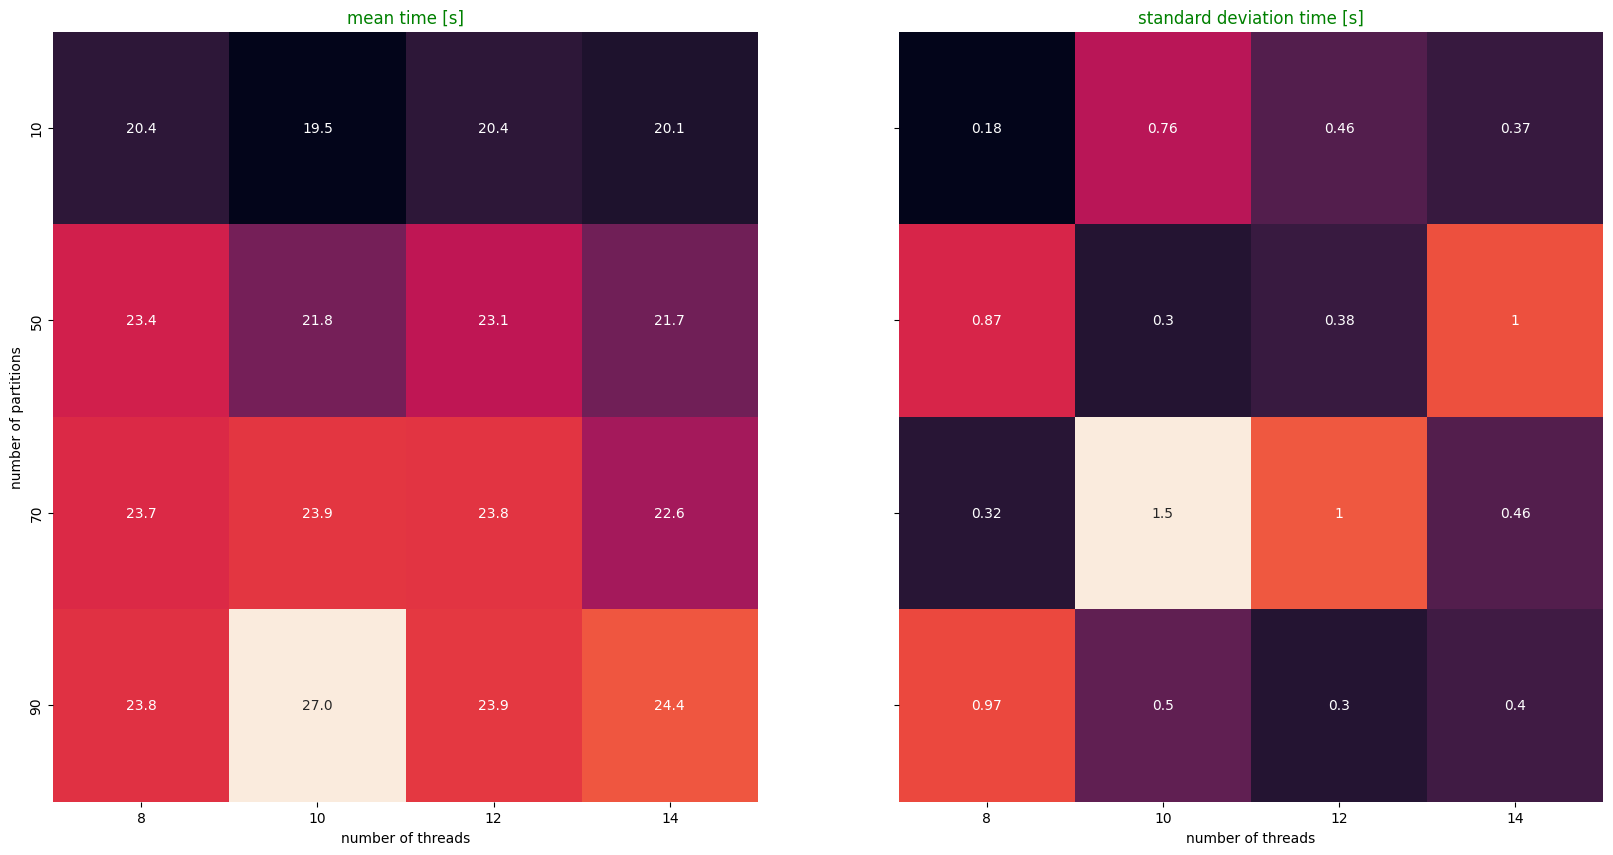

-----------------------n_workers_per_node = 2 ----------------------- 



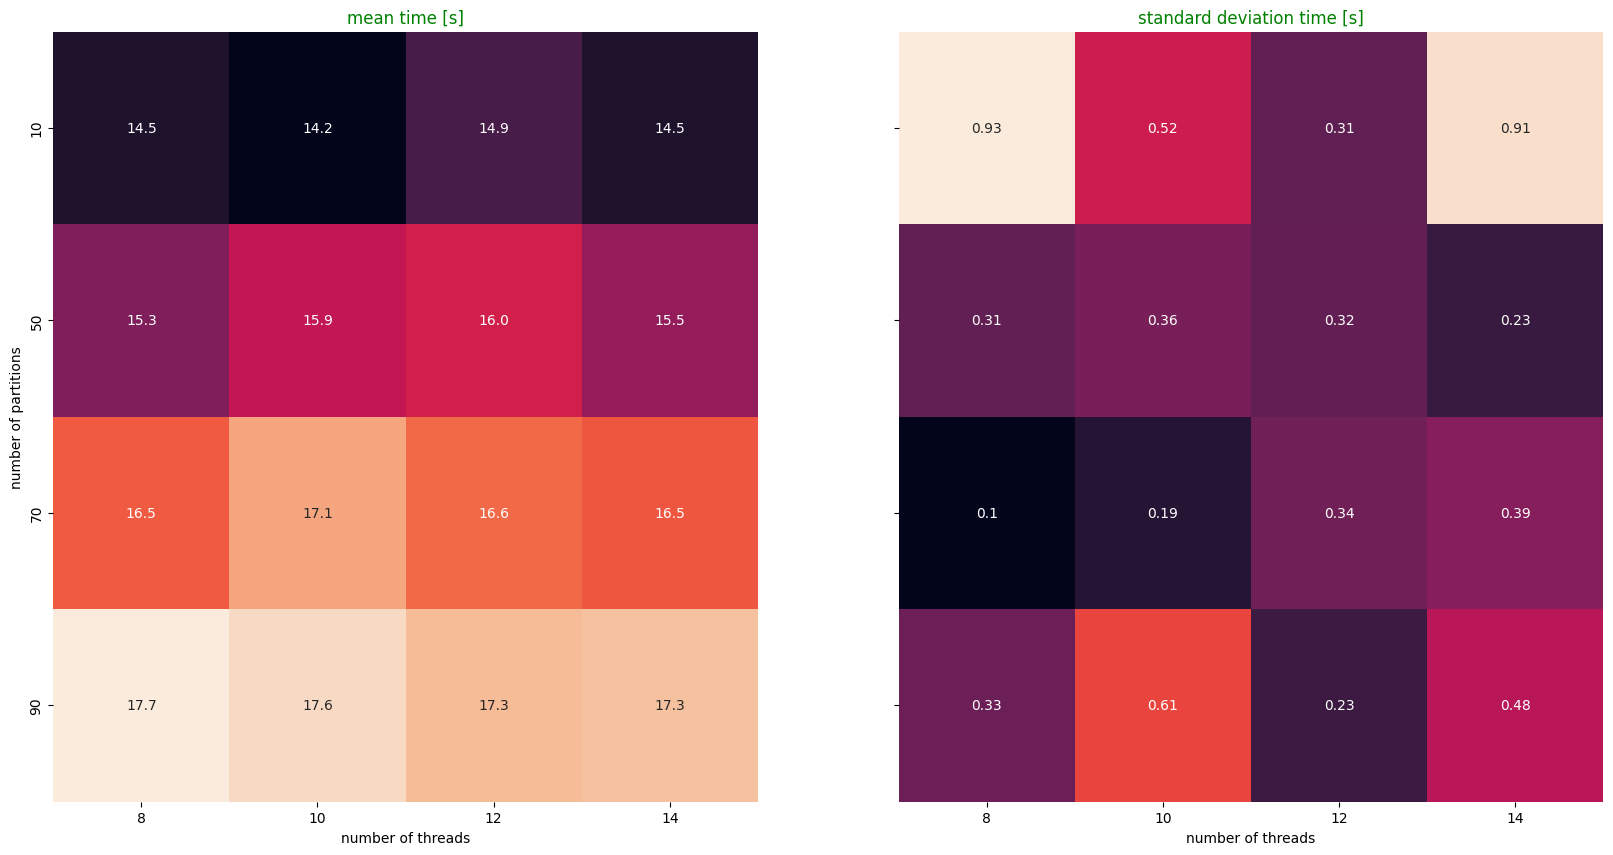

-----------------------n_workers_per_node = 3 ----------------------- 



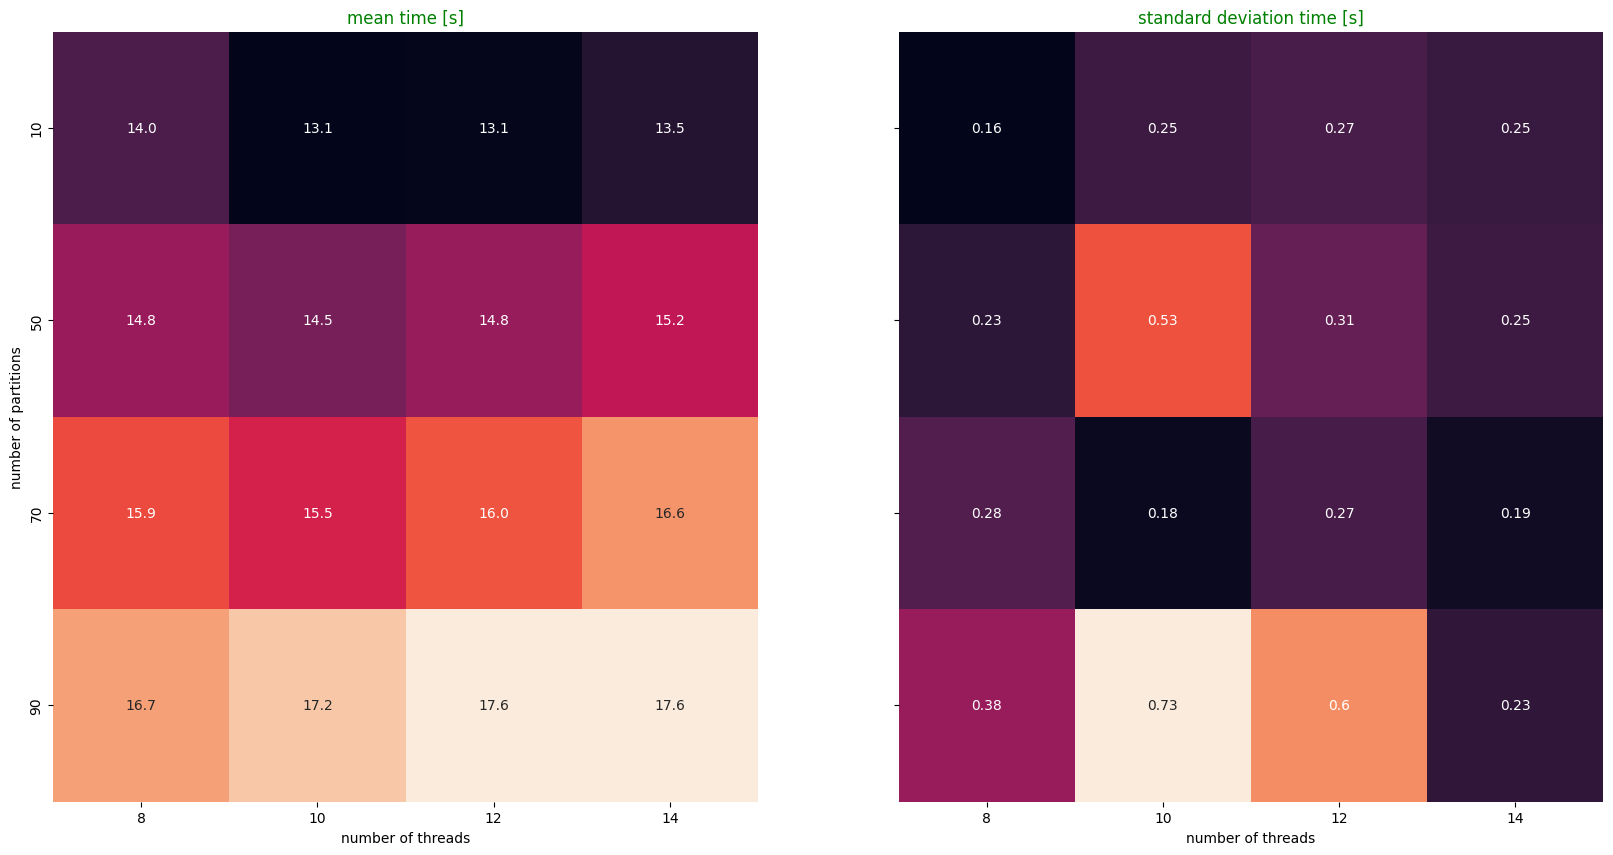

2023-08-29 17:23:56,210 - distributed.deploy.ssh - INFO - 2023-08-29 17:23:56,209 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-08-29 17:23:56,237 - distributed.deploy.ssh - INFO - 2023-08-29 17:23:56,236 - distributed.scheduler - INFO - State start
2023-08-29 17:23:56,239 - distributed.deploy.ssh - INFO - 2023-08-29 17:23:56,238 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7axhaqmb', purging
2023-08-29 17:23:56,239 - distributed.deploy.ssh - INFO - 2023-08-29 17:23:56,239 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dxzbnwob', purging
2023-08-29 17:23:56,240 - distributed.deploy.ssh - INFO - 2023-08-29 17:23:56,240 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6ale9am9', purging
2023-08-29 17:23:56,244 - di

In [ ]:
n_workers = [x for x in range(1,4)]
n_threads = [x for x in range(8,16,2)]
n_partitions = [10,50,70,90]
I = len(n_workers)
J = len(n_threads)
K = len(n_partitions)
mean_matrix = np.zeros((I,J,K))
std_matrix = mean_matrix.copy()

client.close()
cluster.close()

for i in range(0,I):
    for j in range(0,J):

        cluster = SSHCluster([stac3, stac3, stac4, stac5],
                             scheduler_options={"port": 0, "dashboard_address": ":8797"},
                             worker_options={"n_workers": n_workers[i], "nthreads": n_threads[j]},
                             connect_options={"known_hosts": None})
        client = Client(cluster)
        time.sleep(2.0)

        for k in range(0,K):
            timing = %timeit -o -n 2 -r 3 db.read_text(filename).map(json.loads).repartition(n_partitions[k]).pluck("body_text").map(merge_json).map(cleaner).map(count).flatten().foldby('word', binop=sumation,initial=0,combine=add,combine_initial=0).compute()
            mean_matrix[i,j,k] = timing.average
            std_matrix[i,j,k] = timing.stdev
        client.close()
        cluster.close()                            #this also cleans up the memory

#drawing plots

for i in range(0,I):
    print('-----------------------n_workers_per_node = %d -----------------------' % (n_workers[i]),'\n')
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey = True, figsize=(20, 10))
    h_mean = sn.heatmap(mean_matrix[i,:,:].T, xticklabels=n_threads, yticklabels=n_partitions, annot=True, ax=ax1, cbar=False, fmt='.1f')
    h_std = sn.heatmap(std_matrix[i,:,:].T, xticklabels=n_threads, yticklabels=n_partitions, annot=True, ax=ax2, cbar=False)
    ax1.set_title('mean time [s]', color= 'green')
    ax2.set_title('standard deviation time [s]', color='green')
    ax1.set_xlabel('number of threads')
    ax1.set_ylabel('number of partitions')
    ax2.set_xlabel('number of threads')
    #ax2.set_ylabel('number of partitions')
    plt.show()

#saving the best setting and persisting it
min_params = mean_matrix.ravel().argsort()[0]
min_params = np.unravel_index(min_params, shape=mean_matrix.shape)

best_workers_i = min_params[0]
best_threads_i = min_params[1]
best_partitions_i = min_params[2]

best_workers= n_workers[best_workers_i]
best_threads= n_threads[best_threads_i]
best_partitions= n_partitions[best_partitions_i]

cluster = SSHCluster([stac3, stac3, stac4, stac5],
                    scheduler_options={"port": 0, "dashboard_address": ":8797"},
                    worker_options={"n_workers":best_workers, "nthreads":best_threads},
                    connect_options={"known_hosts": None})
client = Client(cluster)

bag = db.read_text(filename)
js = bag.map(json.loads).repartition(best_partitions).persist()

## Task 2: Countries & Universities

In the second task we want to see which countries and universities are the most active in the research.\
We are going to extract these informations from **country** and **affiliation** of the authors.

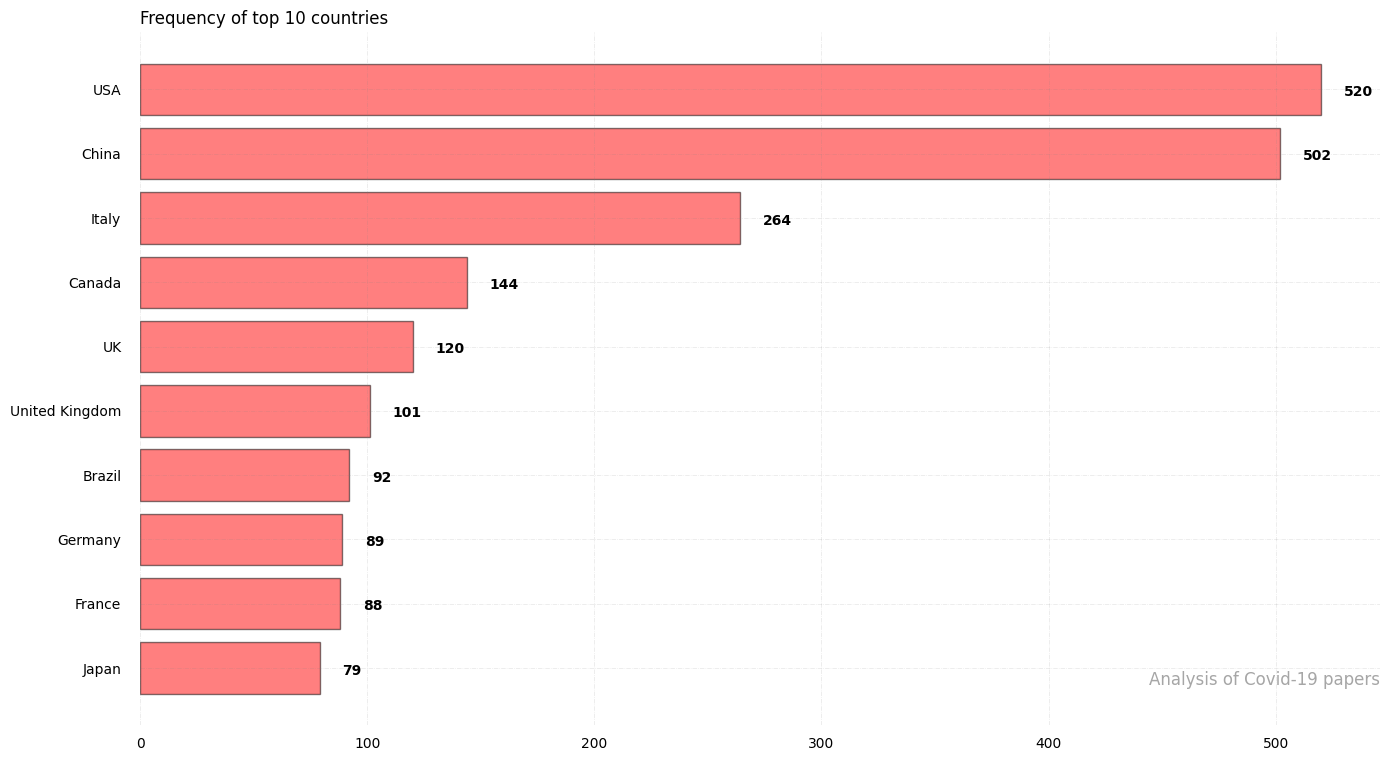

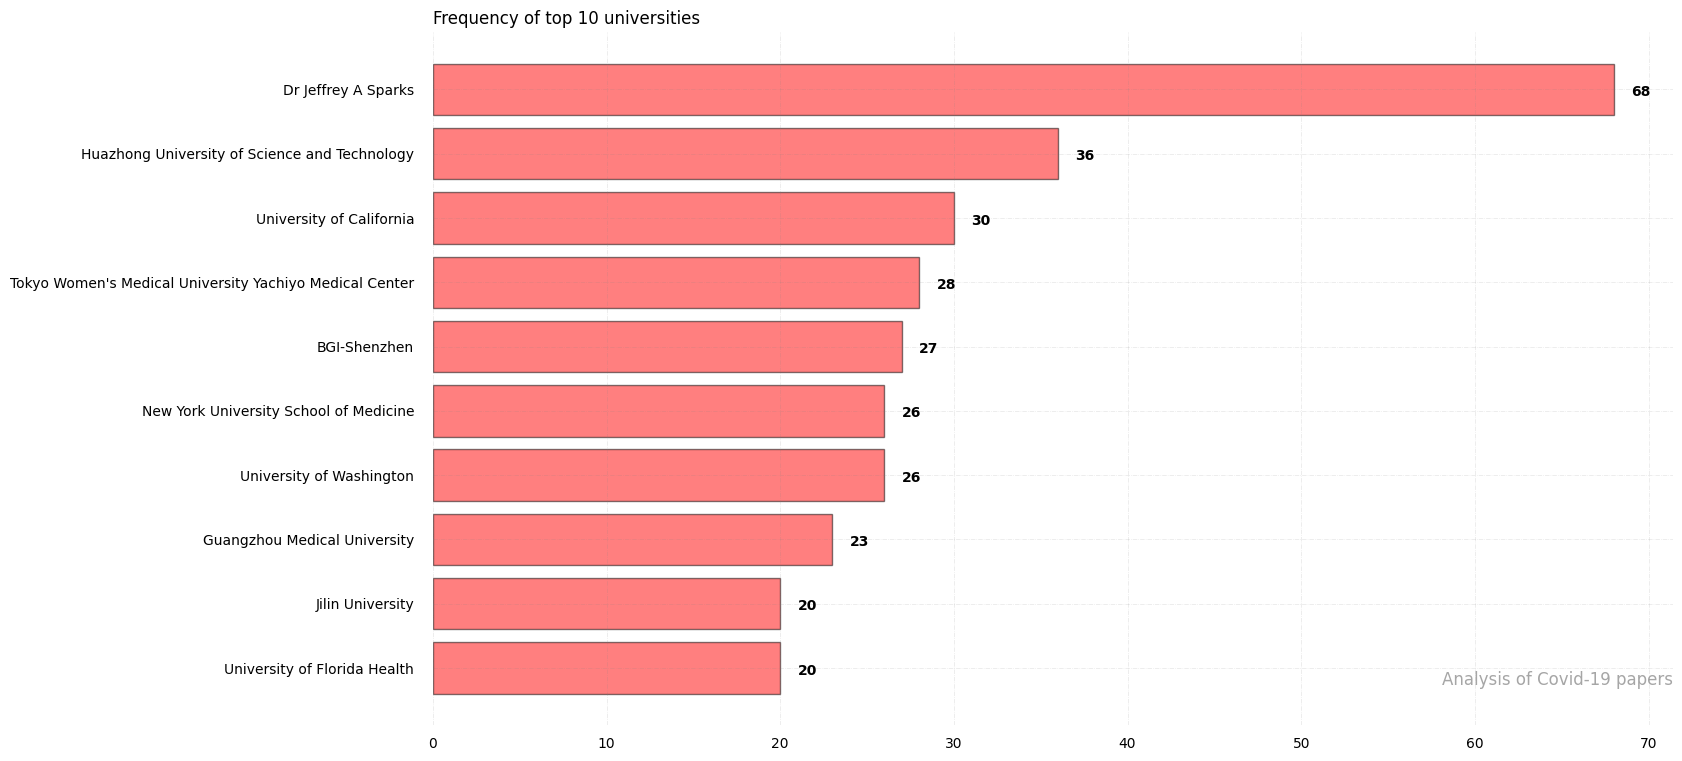

In [ ]:
#let's create the function to extract the needed features
def feat(record):
    name=surname=university=country=''

    name = record['first']
    surname = record['last']

    if record['affiliation'] == {}:
        university = 'Not given'
        country = 'Not given'

    else: #affiliation not void
        if 'institution' in record['affiliation'].keys() and\
        record['affiliation']['institution'] != '': university = record['affiliation']['institution']

        else: university = 'Not given'

    if 'location' in record['affiliation'].keys() and 'country' in record['affiliation']['location'].keys() and\
    record['affiliation']['location']['country'] != '':
        country = record['affiliation']['location']['country']

    else: country = 'Not given'

    return {
        'name':       name,
        'surname':    surname,
        'university': university,
        'country':    country,
    }

#building an author dataframe
authors = js.pluck('metadata').pluck('authors').flatten()
authors_DataFrame = authors.map(feat).to_dataframe()

#counting the country and the universities using built-in method of Dask Dataframes
countries = authors_DataFrame.country.value_counts()
universities = authors_DataFrame.university.value_counts()

#plotting
n=10
data_c = countries.nlargest(n+1).compute()
data_c = data_c[data_c.axes[0]!='Not given']

plot_hist(labels = data_c.axes[0][:n], frequencies = data_c[:n], title = 'Frequency of top 10 countries', count_space = 10)

data_u = universities.nlargest(n+1).compute()
data_u = data_u[data_u.axes[0]!='Not given']

plot_hist(labels = data_u.axes[0][:n], frequencies = data_u[:n], title = 'Frequency of top 10 universities', count_space = 1)

## Task 3: Embeddings

In the third task we want to find the titles that are more correlated each other.\
One way to do it is to transform every word of the title in its embedding version and then to take as embedding represenation of the title the average.\
In order to do that we are going to download an already trained model available on the FastText page: https://fasttext.cc/docs/en/pretrainedvectors.html. \
The model is basically a data frame of $301$ columns and many rows, each one representing the embedding version of a symbol, a letter or a word.\
We will load it as a dask dataframe, drop the last column that contains only **Nans**, filter it, and eventually use it to obtain the embeddings of the titles.\
If a word present on a title is not present on the model we do not use it to compute the embeddings.

In [ ]:
#js = bag.map(json.loads).repartition(10).persist()                        #comment when needed
#upload and filter the model

model = ddf.read_table('/mnt/shared_folder/wiki.en.vec',
                      quoting=csv.QUOTE_NONE,
                      skiprows=1,
                      header=None,
                      sep=' ',
                      blocksize='20MB')

#model = model.repartition(npartitions=500)

def extract_id_title(record):
    ID = record['paper_id']
    title = record['metadata']['title']
    title_tokens = word_tokenize(record['metadata']['title'])
    title_tokens_clean = [word.lower() for word in title_tokens\
                          if not word.lower() in stopwords.words('english') + out_words\
                         and word.isalpha()]

    return{'ID': ID,
          'title': title,
          'title_tokens': title_tokens_clean}

titles = js.map(extract_id_title)
unique_words_title = titles.pluck('title_tokens').flatten().distinct().compute()            #distinct does the reduce operation
mask = model[0].isin(unique_words_title)
filtered_model = model[mask]
filtered_model = filtered_model.drop([301],axis=1).compute()                      #I want this to be a normal pandas dataframe

#-----------------------------------------------------------------------------------------

#transforming each title in its embedding version

def cfr_title_model(record):
    record_dict = {}
    embeddings = []
    word_title_list = record['title_tokens']
    ID = record['ID']
    title = record['title']

    for word in word_title_list:
        if word in filtered_model[0].values:
            embeddings.append(filtered_model[filtered_model[0]== word].loc[:, filtered_model.columns != 0].values)

    embeddings = list(itertools.chain(*embeddings))
    embed_title = np.array([sum(emb)/len(emb) for emb in zip(*embeddings)])
    embed_title = embed_title/norm(embed_title)

    #creating title preview, it is useful to draw the heatmap
    title_pre_tokens = re.findall(r'\w+', title)[:2]
    title_pre = " ".join(title_pre_tokens) + " ..."

    record_dict['title preview'] = title_pre
    record_dict['title'] = title
    record_dict['ID'] = ID
    for i in range(len(embed_title)):
        record_dict['c_'+str(i)] = embed_title[i]

    return record_dict

A = titles.map(cfr_title_model).to_dataframe().dropna()

#--------------------------------------------------------------------------------------------------
# computing the correlation matrix and printing the 25 highest elements
n_h = 25

B=A.drop(['title preview','title','ID'], axis=1).values

cor_mat=(B@B.T).compute()
dim = cor_mat.shape[0]
lower_idxs = np.tril_indices_from(cor_mat, k=0)
cor_mat[lower_idxs] = 0                                #now the correlation matrix is triangular superior
flat_idxs = cor_mat.ravel().argsort()[-n_h:]
mat_idxs = np.unravel_index(flat_idxs, shape=(dim,dim))

max_titles_1 = A['title'].values.compute()[mat_idxs[0]]
max_titles_2 = A['title'].values.compute()[mat_idxs[1]]
max_values = cor_mat[mat_idxs].reshape(n_h,)

pd.set_option('display.max_colwidth', None)
max_corr_df = pd.DataFrame({'paper1': max_titles_1, 'paper2': max_titles_2, 'correlation_value': max_values})
max_corr_df

/home/ubuntu/miniconda3/lib/python3.10/site-packages/dask/array/routines.py:443: PerformanceWarning: Increasing number of chunks by factor of 10
  out = blockwise(


paper1  \
0                                                                                                                                                                                                                            A novel glucocorticoid and androgen receptor modulator reduces viral 1 entry and innate immune inflammatory responses in the Syrian Hamster 2 model of SARS-CoV-2 3 4 2 24 Running Title: Anti-SARS-CoV-2 activity of a corticosteroid receptor inhibitor   
1                                                                                                                                                                                                                                                                                     A molecular docking study revealed that synthetic peptides induced conformational changes in the structure of SARS-CoV-2 spike glycoprotein, disrupting the interaction with human ACE2 receptor   
2                                                                                                                                                                                                                                                                                                                                                                                Recent Insights Into the Molecular Mechanism of Toll-Like Receptor Response to Dengue Virus Infection   
3   Journal Pre-proof Impact On Clinical Practice Of The Preoperative Screening Of Covid-19 Infection In Surgical Oncological Patients. Prospective Cohort Study TITLE PAGE IMPACT ON CLINICAL PRACTICE OF THE PREOPERATIVE SCREENING OF COVID-19 INFECTION IN SURGICAL ONCOLOGICAL PATIENTS. PROSPECTIVE COHORT STUDY CORRESPONDING AUTHOR IMPACT ON CLINICAL PRACTICE OF THE PREOPERATIVE SCREENING OF COVID-19 INFECTION IN SURGICAL ONCOLOGICAL PATIENTS. PROSPECTIVE COHORT STUDY   
4                                                                                                                                                                                                                                                                                                                                                                                                                      0123456789) 1 3 Journal of Racial and Ethnic Health Disparities   
5                                                                                                                                                                                                                                                                                                                                                                                                                                                      Supplementary material Contents   
6                                                                                                                                                                                                                                                                                     A molecular docking study revealed that synthetic peptides induced conformational changes in the structure of SARS-CoV-2 spike glycoprotein, disrupting the interaction with human ACE2 receptor   
7                                                                                                                                                                                                                                                                                                                                                                                                                           Pan America Health Organization, World Health Organization   
8                                                                                                                                                                                                     

## Timing for loading and filtering the model
In particular, we are insterested in the change of execution time varying the **dimension chuncks** to load the model and the **number of repartitions** of the model itself, the settings of the cluster will be left unchanged, instead.

-------------------------------dimension of chuncks = 10MB, number of repartitions = 0 ---------------------------
-------------------------------dimension of chuncks = 10MB, number of repartitions = 500 ---------------------------
-------------------------------dimension of chuncks = 10MB, number of repartitions = 800 ---------------------------
-------------------------------dimension of chuncks = 10MB, number of repartitions = 1000 ---------------------------
-------------------------------dimension of chuncks = 20MB, number of repartitions = 0 ---------------------------
-------------------------------dimension of chuncks = 20MB, number of repartitions = 500 ---------------------------


2023-08-29 17:47:23,588 - distributed.client - WARNING - Couldn't gather 13 keys, rescheduling {"('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 174)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 404)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 146)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 1)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 124)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 45)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 324)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 336)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 255)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 372)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 437)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 425)": (), "('drop_by_shallow_copy-5da2a0f869aea7fb778d96cb89c97c90', 401)": (

-------------------------------dimension of chuncks = 20MB, number of repartitions = 800 ---------------------------


2023-08-29 17:56:12,366 - distributed.client - WARNING - Couldn't gather 2 keys, rescheduling {"('drop_by_shallow_copy-3423fe334f7db3d4c6b9ccfd8e1866d5', 625)": (), "('drop_by_shallow_copy-3423fe334f7db3d4c6b9ccfd8e1866d5', 624)": ()}


-------------------------------dimension of chuncks = 20MB, number of repartitions = 1000 ---------------------------


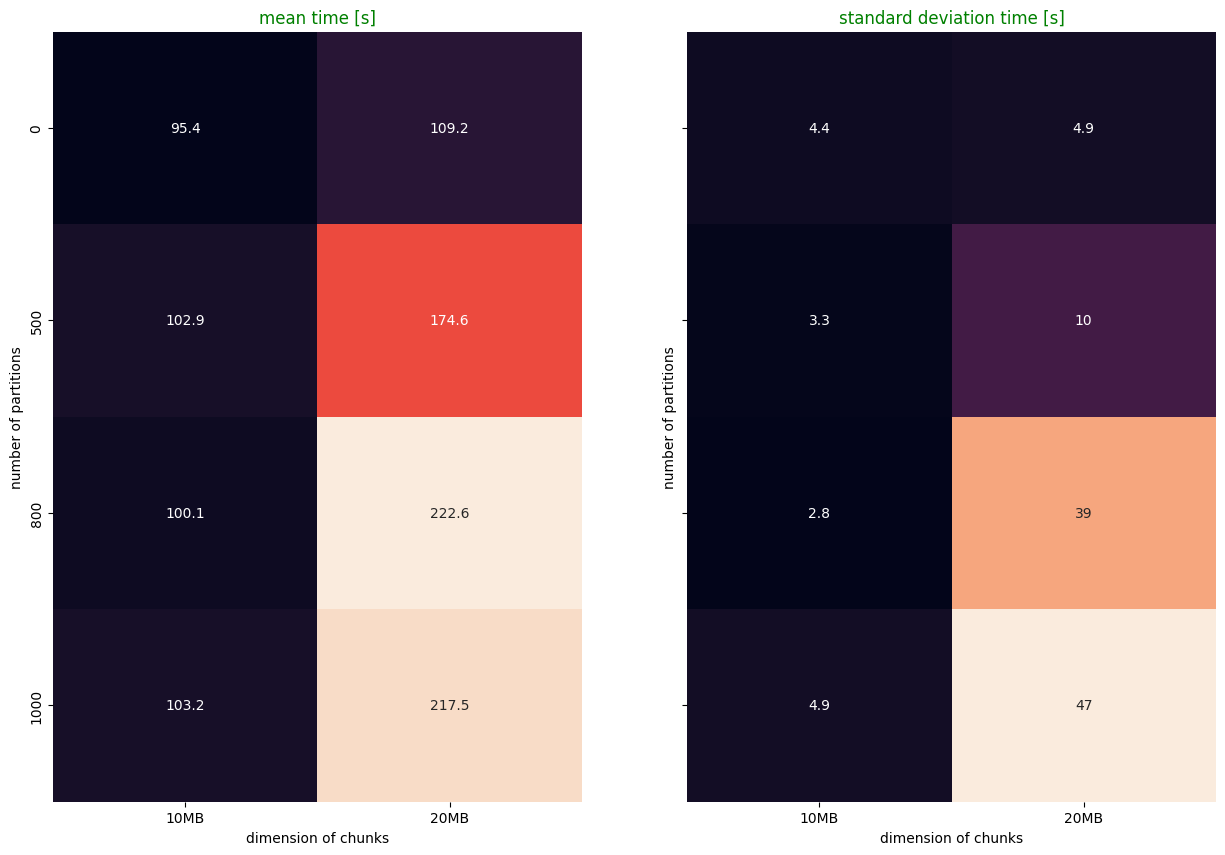

In [ ]:
#timing----------------------------------------------------------------------------------------
d_chunks = ['10MB','20MB']
n_partitions = [0,500,800,1000]
Q = len(d_chunks)
K = len(n_partitions)

avg_matrix = np.zeros((Q,K))
dev_matrix = avg_matrix.copy()

task_template = """
model = ddf.read_table('/mnt/shared_folder/wiki.en.vec',
                      quoting=csv.QUOTE_NONE,
                      skiprows=1,
                      header=None,
                      sep=' ',
                      blocksize = '{dc}')

{repartition_step}
titles = js.map(extract_id_title)
unique_words_title = titles.pluck('title_tokens').flatten().distinct().compute()
mask = model[0].isin(unique_words_title)
filtered_model = model[mask]
filtered_model.drop([301],axis=1).compute()
"""

for q in range(0, Q):
    for k in range(0, K):
        print('-------------------------------dimension of chuncks = %s, number of repartitions = %d ---------------------------' %(d_chunks[q],n_partitions[k]))
#---------------------------------------restarting client to have a clear state  and reloading data----------------------------------------
        client.restart()
        time.sleep(5.0)
        filename = '/mnt/shared_folder/papers_one_line/*.json'
        bag = db.read_text(filename)
        js = bag.map(json.loads).repartition(10).persist()

        if n_partitions[k] == 0:
            repartition_step = ""  # No repartitioning
        else:
            repartition_step = f"model = model.repartition(npartitions={n_partitions[k]})"

        task_code = task_template.format(dc=d_chunks[q], repartition_step=repartition_step)

        timing = timeit.repeat(task_code, repeat=2, number=2, globals=globals())
        avg_matrix[q, k] = np.mean(timing)
        dev_matrix[q, k] = np.std(timing)

#plotting
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey = True, figsize=(15, 10))
h_mean = sn.heatmap(avg_matrix.T, xticklabels=d_chunks, yticklabels=n_partitions, annot=True, ax=ax1, cbar=False, fmt='.1f')
h_std = sn.heatmap(dev_matrix.T, xticklabels=d_chunks, yticklabels=n_partitions, annot=True, ax=ax2, cbar=False)
ax1.set_title('mean time [s]', color= 'green')
ax2.set_title('standard deviation time [s]', color='green')
ax1.set_xlabel('dimension of chunks')
ax1.set_ylabel('number of partitions')
ax2.set_xlabel('dimension of chunks')
ax2.set_ylabel('number of partitions')
plt.show()

## Network of authors

In this last part we want to compute who are the 'most central authors'.\
Firstly we will find the edges between couples of authors who collaborated in the same paper.\
That way will be able to build a network that displays the collaboration between scientists.\
We are going to plot an histogram of the twenty highest degree researchers.


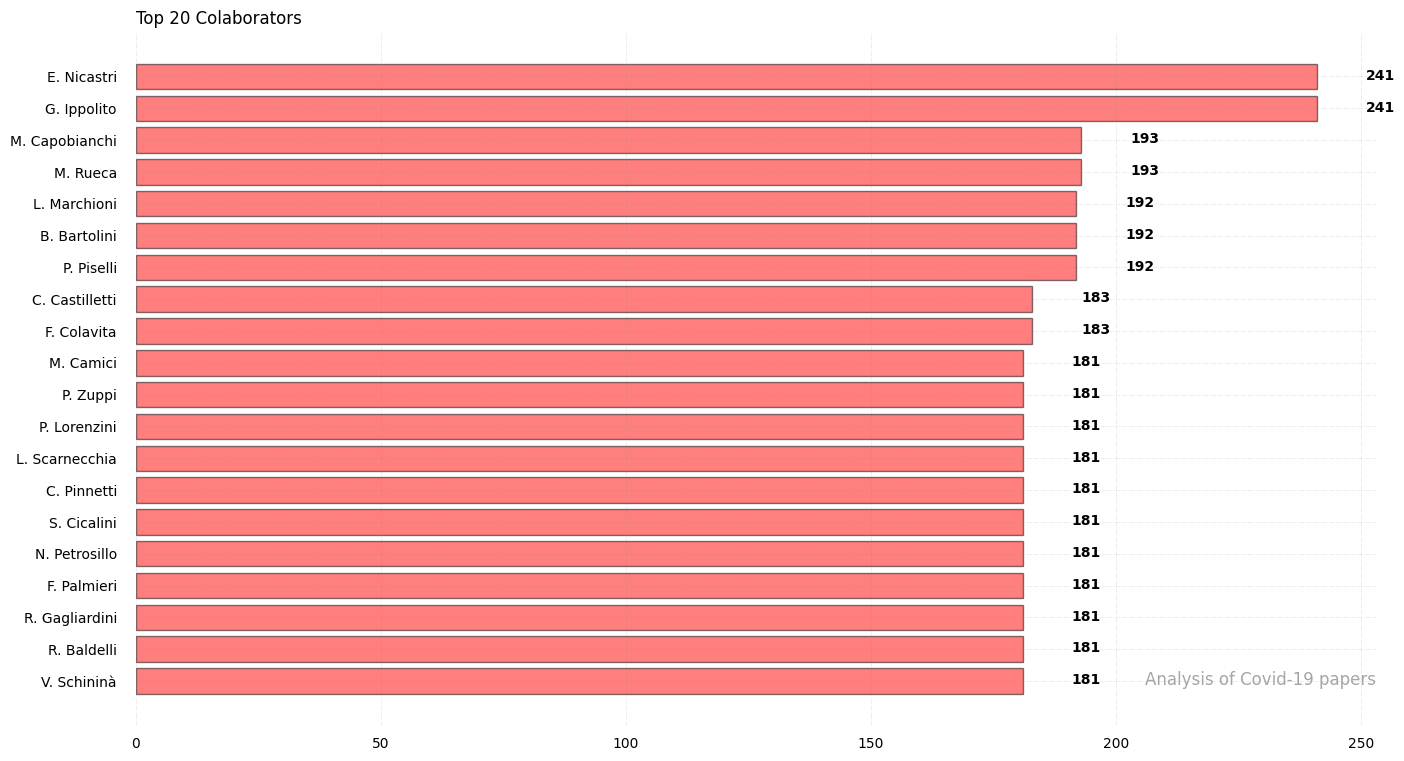

In [ ]:
# Function to process each author and generate the desired record
def process_edges(authors):
    edges_list = []

    # Generate all possible pairs of authors
    author_pairs = list(combinations(authors, 2))

    for pair in author_pairs:
        author1 = pair[0]
        author2 = pair[1]

        # Check if author names are not empty and contain at least two characters
        if author1['first'].isalpha() and author1['last'].isalpha() and len(author1['first']) > 1 and len(author1['last']) > 1:
            name1 = author1['first'][0].strip() + '. ' + author1['last'].strip()
        else:
            continue

        if author2['first'].isalpha() and author2['last'].isalpha() and len(author2['first']) > 1 and len(author2['last']) > 1:
            name2 = author2['first'][0].strip() + '. ' + author2['last'].strip()
        else:
            continue

        if str(name1[0]) <= str(name2[0]):
            edg = name1 + ' , ' + name2
        else:
            edg = name2 + ' , ' + name1

        count = 1

        edges_list.append({'edges': edg, 'frequency': count})

    return (edges_list)

#function to compute the degree of nodes starting from edges
def process_nodes(edge_record):
    authors = edge_record[0].split(' , ')
    return ({'node': authors[0], 'frequency' : 1}, {'node': authors[1], 'frequency' : 1})

#------------------------------------computing edges-------------------------
edges = js.pluck('metadata').pluck('authors').map(process_edges).flatten()
counted_edges = edges.foldby(key='edges',binop=sumation,
                             initial=0,
                             combine=add,
                             combine_initial=0).compute()
edges_bag = db.from_sequence(counted_edges)

#----------------------------------computing degree------------------------------
local_deg = edges_bag.map(process_nodes).flatten()
global_deg = local_deg.foldby(key='node',binop=sumation,
                             initial=0,
                             combine=add,
                             combine_initial=0).compute()
global_deg = sorted(global_deg, key = itemgetter(1), reverse = True)

#----------------------------------plotting degree of nodes--------------------------------------------
names = [name for name, _ in global_deg]
counts = [count for _, count in global_deg]

plot_hist(labels = names[:20], frequencies =  counts[:20], title='Top 20 Colaborators', count_space=10)

### Displaying the Network

We will display the nodes and edges, of the 70 most central authors. The more central the author is (highest degree), the more it is placed close to the center. The thickness of the arrows indicates the weights of the connections, or the number of times a couple of authors collaborated together

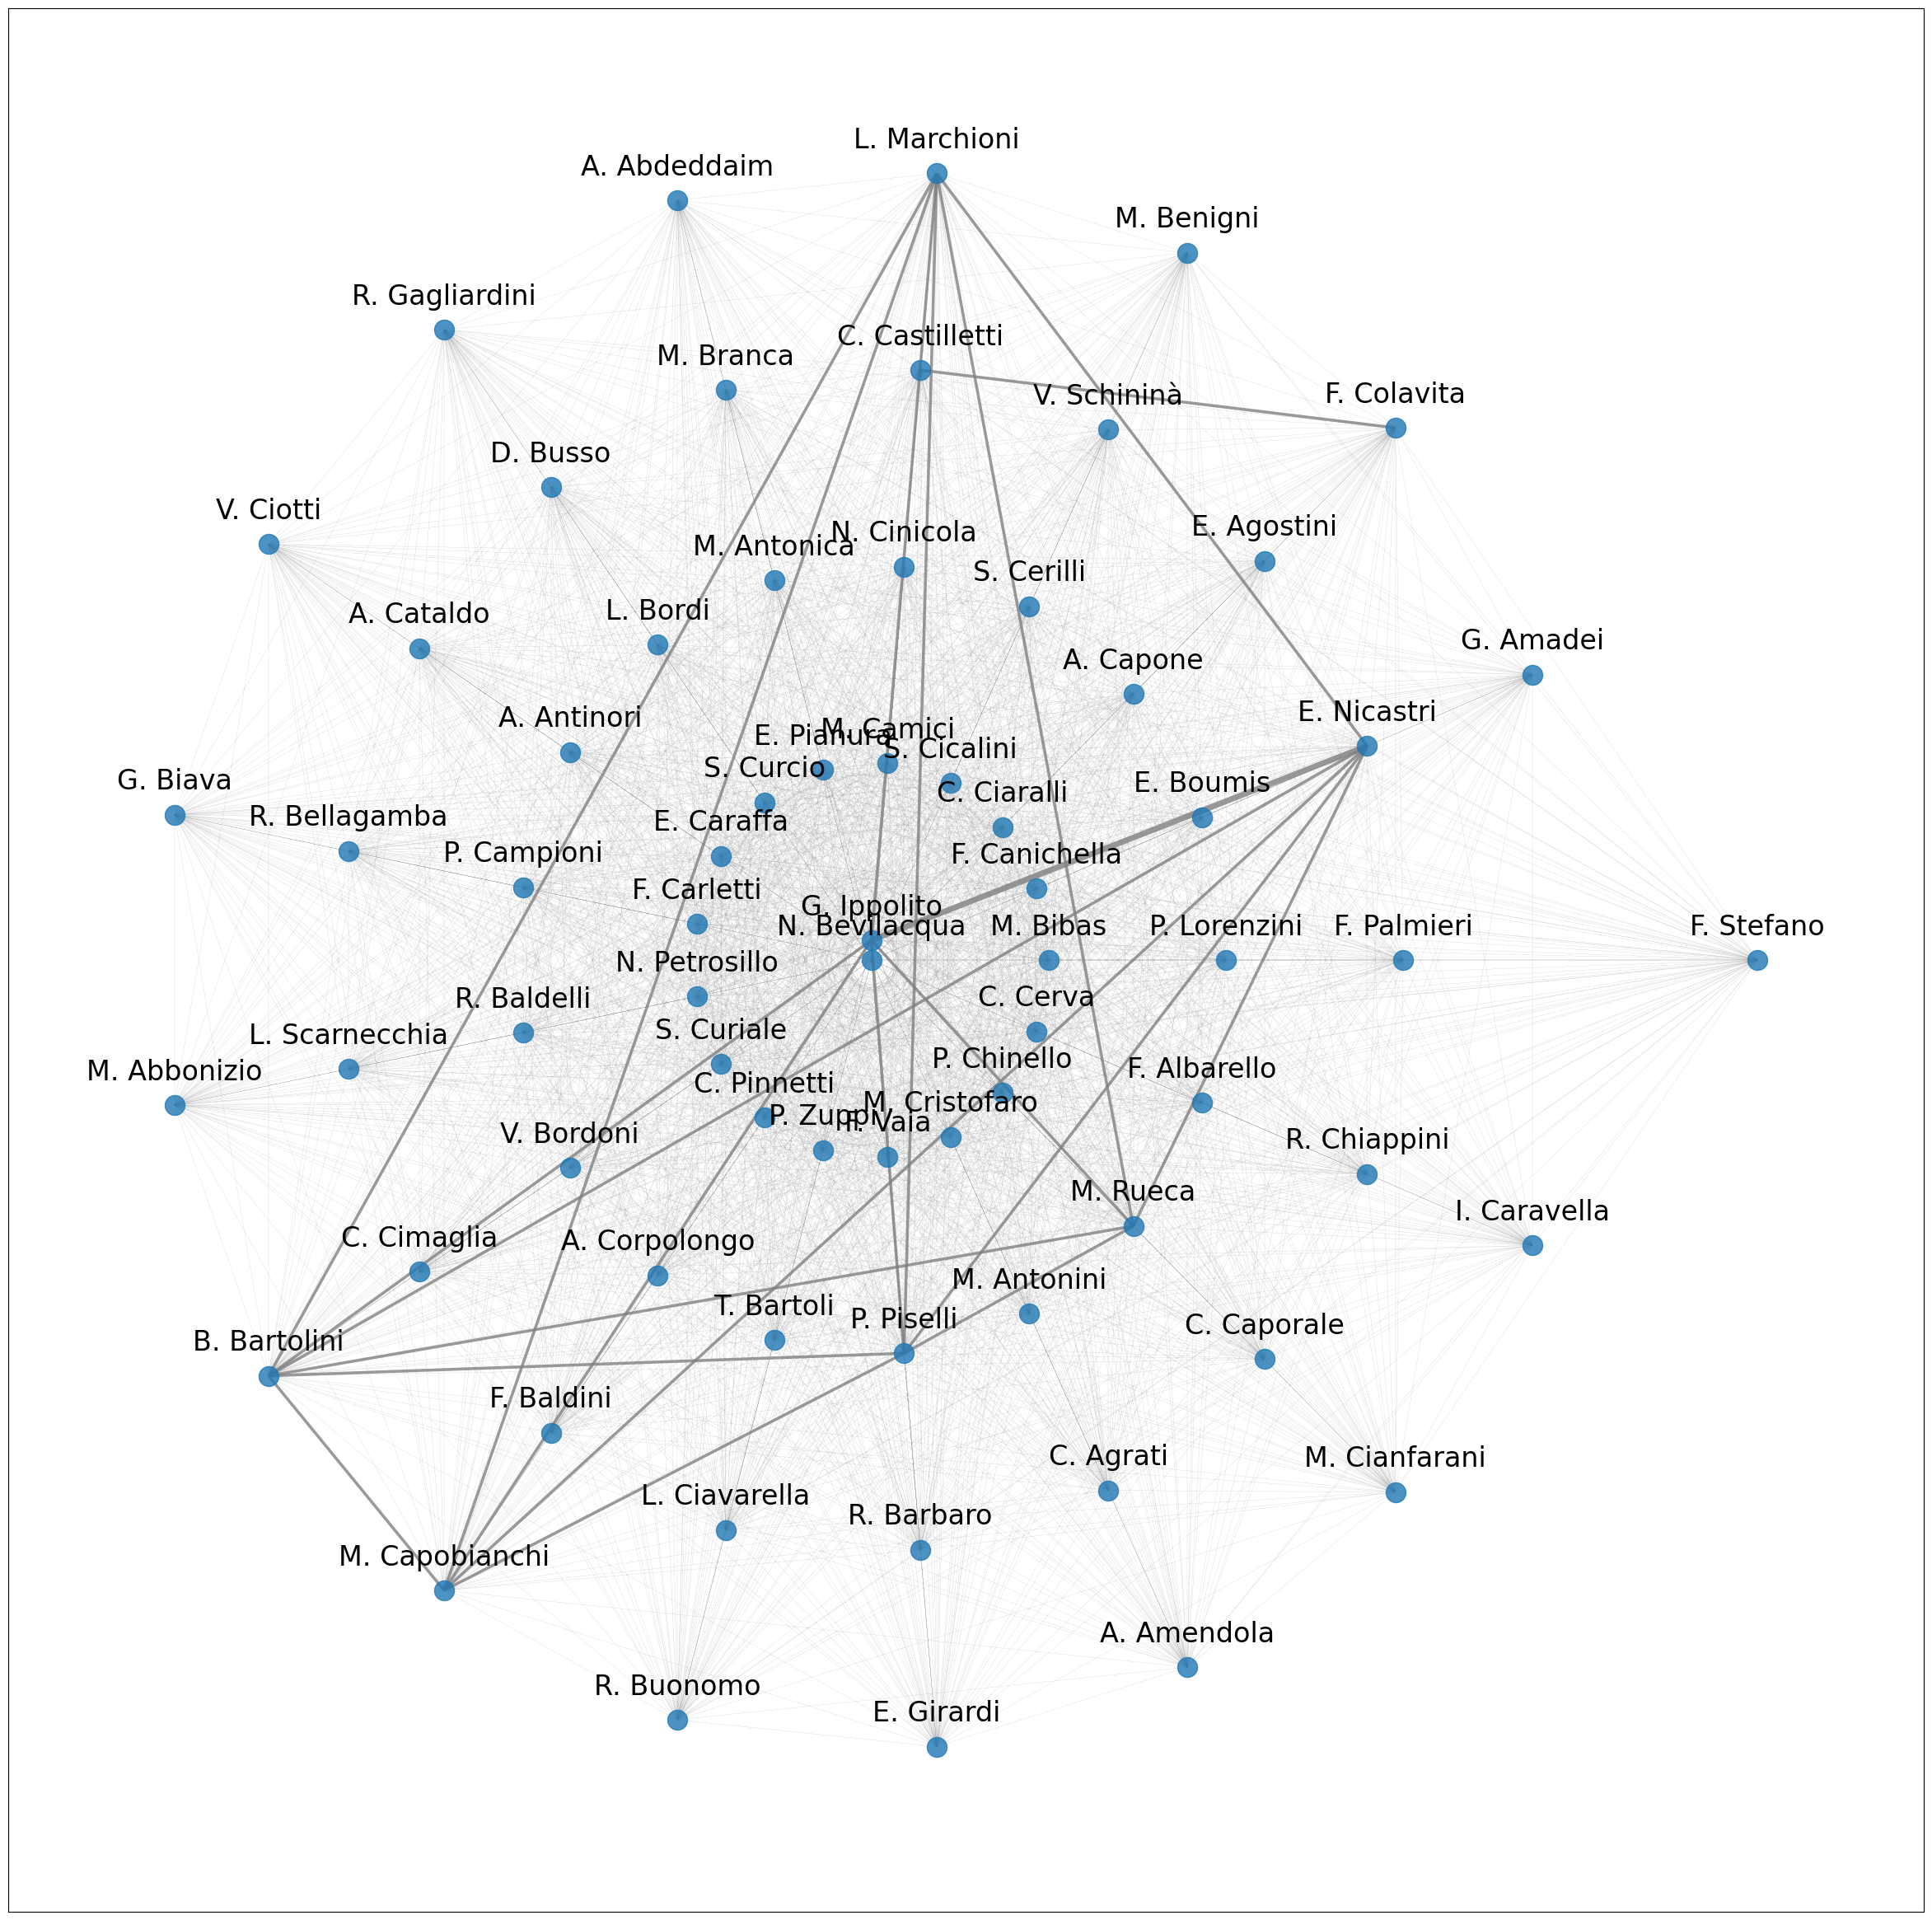

In [ ]:
# Create an undirected graph
G = nx.Graph()

# Add edges with weights to the graph
for edges in counted_edges:
    author=edges[0].split(" , ")
    G.add_edge(author[0], author[1], weight=edges[1])

# Determine the nodes with the highest degree (display how many nodes you wish)
n_of_nodes_to_display=70
highest_degrees_ = [node for node,_ in global_deg[:n_of_nodes_to_display]]

# Create a subgraph with the highest degree nodes, excluding self-edges
subgraph = G.subgraph(highest_degrees_).copy()
subgraph.remove_edges_from(nx.selfloop_edges(subgraph))

# Create a layout for the subgraph
layout = {}
sorted_nodes = sorted(subgraph.nodes(), key=lambda x: subgraph.degree[x], reverse=True)
num_circles = 4

# Calculate the number of nodes in each circle, excluding the highest degree node
num_nodes_per_circle = (len(sorted_nodes) - 1) // num_circles

# Assign positions for each node
for i, node in enumerate(sorted_nodes):
    if node == highest_degrees_[0]:
        # Place the highest degree node in the center
        layout[node] = (0, 0)
    if node == highest_degrees_[1]:
        # Place the second higher degree node near the center
        layout[node] = (0, 0.03)
    else:
        circle_index = (i - 1) // num_nodes_per_circle
        angle = ((i - 1) % num_nodes_per_circle) * (2 * np.pi / num_nodes_per_circle)
        radius = (circle_index + 1) * 0.3
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        layout[node] = (x, y)

# Extract edge weights
weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]

# Normalize weights between 0.1 and 5 (adjust the range as needed)
normalized_weights = np.interp(weights, (min(weights), max(weights)), (0.1, 5))

# Compute the node positions using spring layout
pos = nx.spring_layout(subgraph)
plt.figure(figsize=(30, 30))
nx.draw_networkx(
    subgraph,
    pos=layout,
    with_labels=False,
    node_size=300,
    font_size=24,
    font_color='black',
    edge_color='gray',
    width=normalized_weights,  # Use normalized weights for edge thickness
    alpha=0.8
)

# Adjust label positions
label_pos = {k: (x, y + 0.05) for k, (x, y) in layout.items()}
nx.draw_networkx_labels(subgraph, pos=label_pos, font_size=24)

plt.show()

In [ ]:
client.close()
cluster.close()